In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
data_dir = "cotton-plant-disease-data"

In [18]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

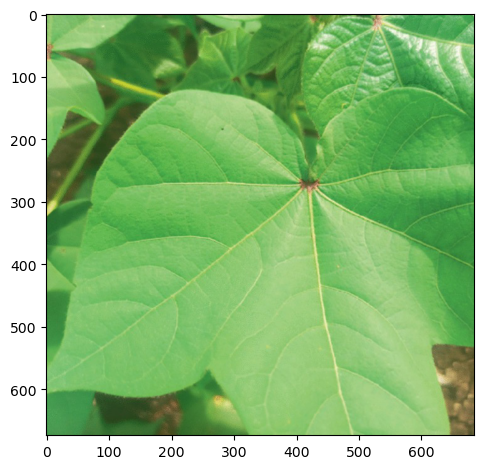

In [19]:
import matplotlib.image as mping
test_image = "cotton-plant-disease-data/Healthy leaf/1.jpg"
img = mping.imread(test_image)
plt.imshow(img)
save_fig("sample-healthy-leaf")

In [20]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 237 files belonging to 6 classes.
Using 190 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 237 files belonging to 6 classes.
Using 47 files for validation.


In [23]:
class_names = train_ds.class_names
class_names

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy leaf',
 'Powdery Mildew',
 'Target spot']

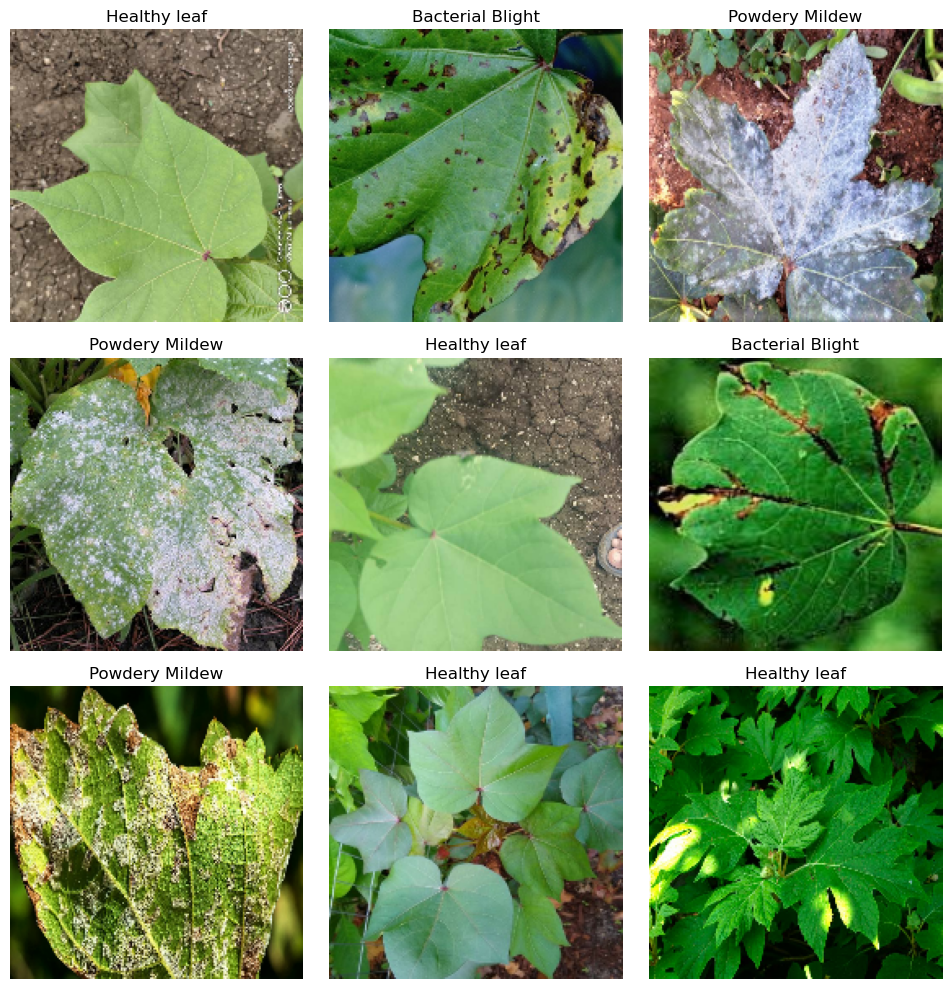

In [25]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_diseases_images")

In [26]:
# manually iterate of the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [27]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
# Standardize values to be in the [0,1] RGB channel range by using tf.keras.Rescaling
normalization_layers = layers.Rescaling(1./255)

In [29]:
# create a keras model

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [30]:
# compile our model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [32]:
# train the model for 10 epochs
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 15s 2s/step - loss: 2.1209 - accuracy: 0.1684 - val_loss: 1.7624 - val_accuracy: 0.1915
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 1.7089 - accuracy: 0.2474 - val_loss: 1.5641 - val_accuracy: 0.3191
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 1.6063 - accuracy: 0.2842 - val_loss: 1.4636 - val_accuracy: 0.4255
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 1.3630 - accuracy: 0.5421 - val_loss: 1.3480 - val_accuracy: 0.5745
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 1.0779 - accuracy: 0.6474 - val_loss: 1.1798 - val_accuracy: 0.5957
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.8281 - accuracy: 0.7263 - val_loss: 1.0105 - val_accuracy: 0.5957
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.5288 - accuracy: 0.8579 - val_loss: 1.2533 - val_accuracy: 0.6170
Epoch 8/10
6/6 [========================

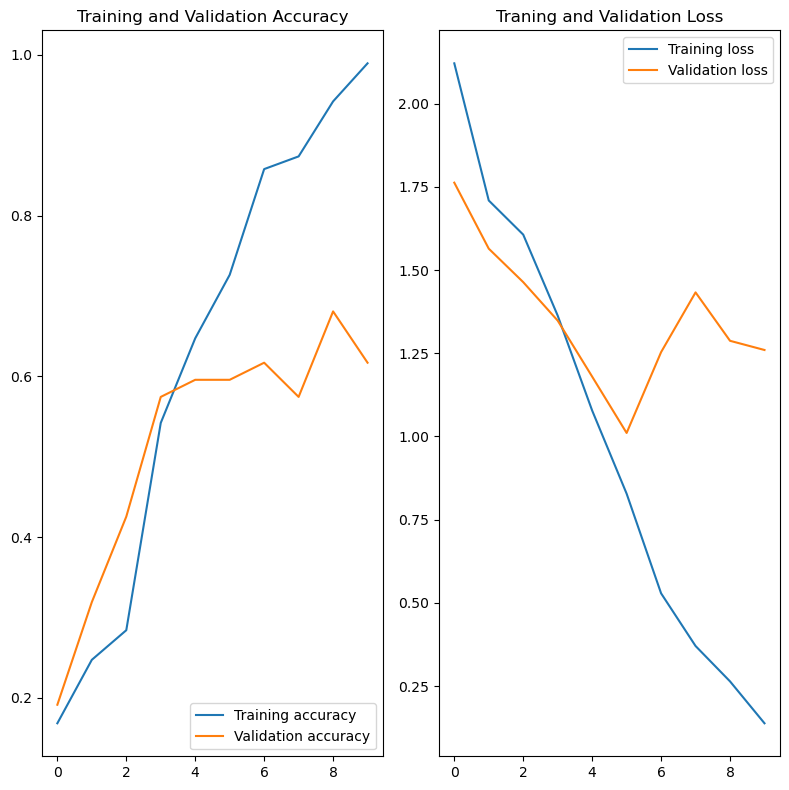

In [33]:
# visualize training results by creating plots for loss and accuracy on training and validation sets

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Traning and Validation Loss")
save_fig("training_and_validation_accuracy_and_loss_1")
plt.show()

In [34]:
# Reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

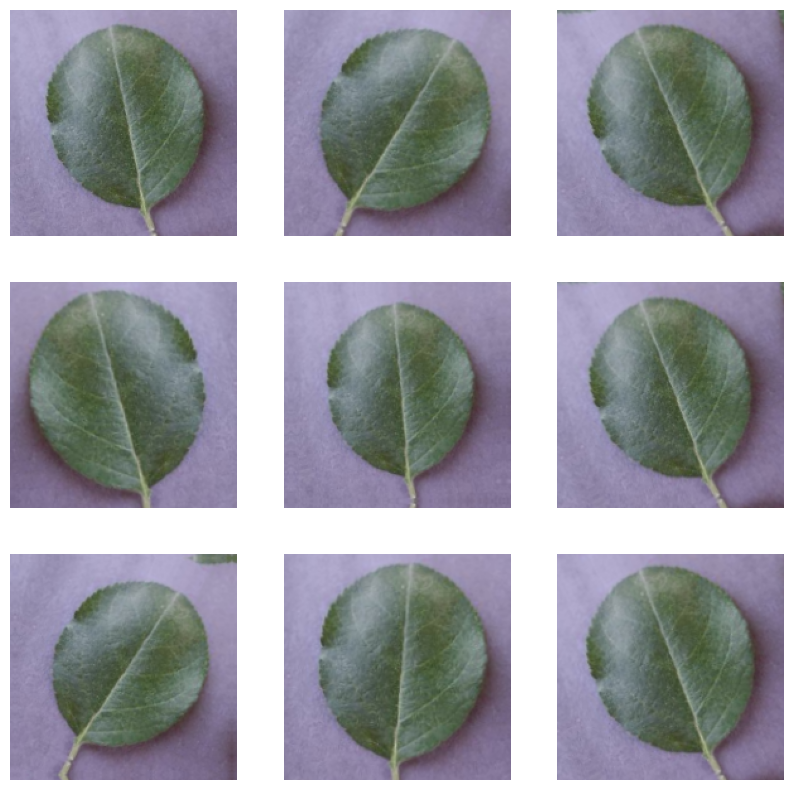

In [18]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [19]:
# introduce Dropout in the network to help reduce overfitting further

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [20]:
# compile and train the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
43/43 [==============================] - 63s 1s/step - loss: 0.6752 - accuracy: 0.6330 - val_loss: 0.4515 - val_accuracy: 0.7713
Epoch 2/15
43/43 [==============================] - 56s 1s/step - loss: 0.3671 - accuracy: 0.8348 - val_loss: 0.4312 - val_accuracy: 0.8152
Epoch 3/15
43/43 [==============================] - 56s 1s/step - loss: 0.2545 - accuracy: 0.8977 - val_loss: 0.3924 - val_accuracy: 0.8475
Epoch 4/15
43/43 [==============================] - 57s 1s/step - loss: 0.2959 - accuracy: 0.8860 - val_loss: 0.2503 - val_accuracy: 0.8856
Epoch 5/15
43/43 [==============================] - 56s 1s/step - loss: 0.2525 - accuracy: 0.9050 - val_loss: 0.2104 - val_accuracy: 0.9355
Epoch 6/15
43/43 [==============================] - 56s 1s/step - loss: 0.2044 - accuracy: 0.9218 - val_loss: 0.1961 - val_accuracy: 0.9267
Epoch 7/15
43/43 [==============================] - 57s 1s/step - loss: 0.1647 - accuracy: 0.9423 - val_loss: 0.1742 - val_accuracy: 0.9472
Epoch 8/15
43/43 [==

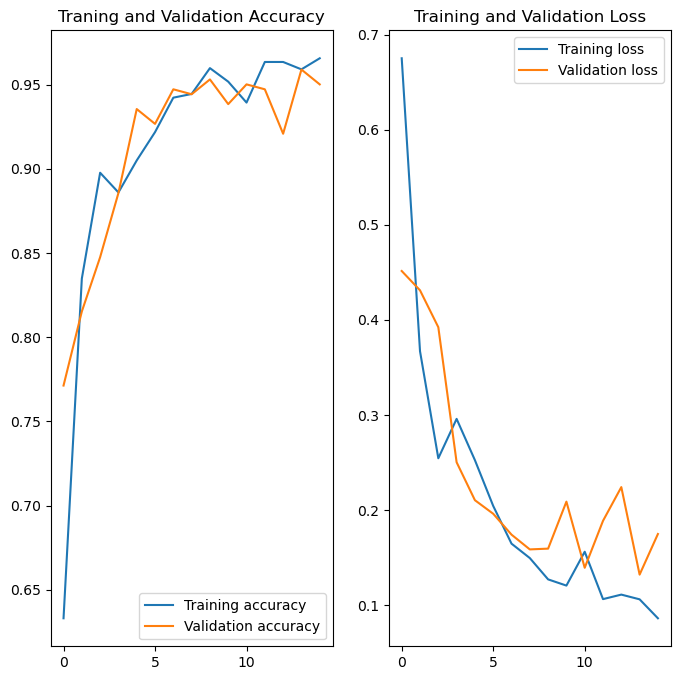

In [23]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [24]:
# predict on new data
img = tf.keras.utils.load_img(
    "crop-disease-data/test.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100* np.max(score))
)

1/1 [==============================] - 0s 204ms/step
This image most likely belongs to diseased with a 100.00 percent confidence.


In [25]:
# # convert the model to tensorflow lite

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # save the model

# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [26]:
# # run the tensorflow lite model
# TF_MODEL_FILE_PATH = 'model.tflite'
# interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [27]:
# # print the signatures of the converted model to get the names of the inputs and outputs

# interpreter.get_signature_list()

In [28]:
# # test the loaded model

# classify_lite = interpreter.get_signature_runner('serving_default')
# classify_lite

In [29]:
# # make predictions using tensorflow lite model

# predictions_lite = classify_lite(sequential_2_input = img_array)['outputs']
# score_lite = tf.nn.softmax(predictions_lite)

In [30]:
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score_lite)],  100 * np.max(score_lite))
# )

In [31]:
import os
import json
import tempfile
import requests

In [32]:
MODEL_DIR = 'ML/models/crop_disease_model'
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print('\nexport_path = {}'.format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/crop_disease_model\1\assets


INFO:tensorflow:Assets written to: ML/models/crop_disease_model\1\assets



export_path = ML/models/crop_disease_model\1


Invalid switch - "models".


In [33]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_sequential_1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The MetaGraph with tag set ['serve'] contains the following ops: {'ReadVariableOp', 'RestoreV2', 'NoOp', 'Ad